# Pool Shark Experimentation

## Setup

In [3]:
import matplotlib.pyplot as plt
from roboflow import Roboflow
import supervision as sv
import numpy as np
from PIL import Image
import requests
from ultralytics import YOLO
import cv2
import math
import os

In [4]:
def display_images_grid(images, grid_size=(2, 2), figsize=(8, 8)):
    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=figsize)

    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

    for i, ax in enumerate(axs):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis('off')  
        else:
            ax.axis('off')  

    plt.tight_layout()
    plt.show()

## Image Init

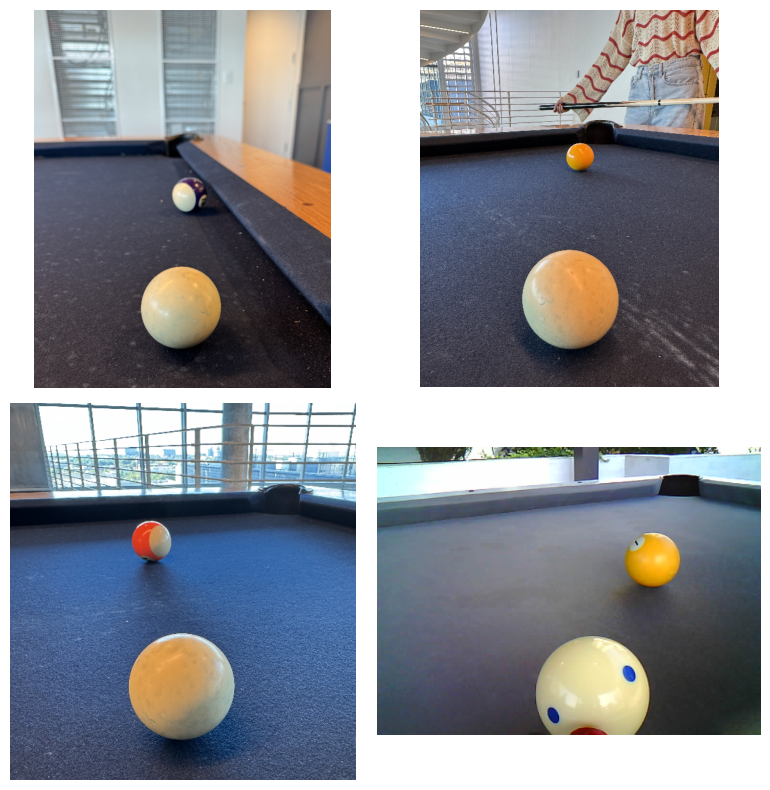

In [23]:
# for cue ball in
# image_paths = ['Images/5.JPG', 'Images/6.JPG', 'Images/7.JPG', 'Images/8.JPG']
# for cut shots
image_paths = ['Images/1.JPG', 'Images/3.JPG', 'Images/4.JPG', 'esp32_cam_image.JPG']

raw_images = []
resized_images = []

for path in image_paths:
    image = cv2.imread(path)
    raw_images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    image_height, image_width = image.shape[:2]
    resized_image = cv2.resize(image, (500, int(500 * image_height / image_width)))
    resized_images.append(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  
    
display_images_grid(resized_images, grid_size=(2, 2))

## Just Identify


image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_0.jpg: 640x512 2 balls, 296.0ms
Speed: 2.0ms preprocess, 296.0ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_0.jpg: 640x512 1 pocket, 205.2ms
Speed: 9.1ms preprocess, 205.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_1.jpg: 640x512 2 balls, 191.7ms
Speed: 0.0ms preprocess, 191.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_1.jpg: 640x512 1 pocket, 234.6ms
Speed: 0.0ms preprocess, 234.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_2.jpg: 640x608 2 balls, 249.1ms
Speed: 12.3ms preprocess, 249.1ms inference, 0.0ms postprocess per image at

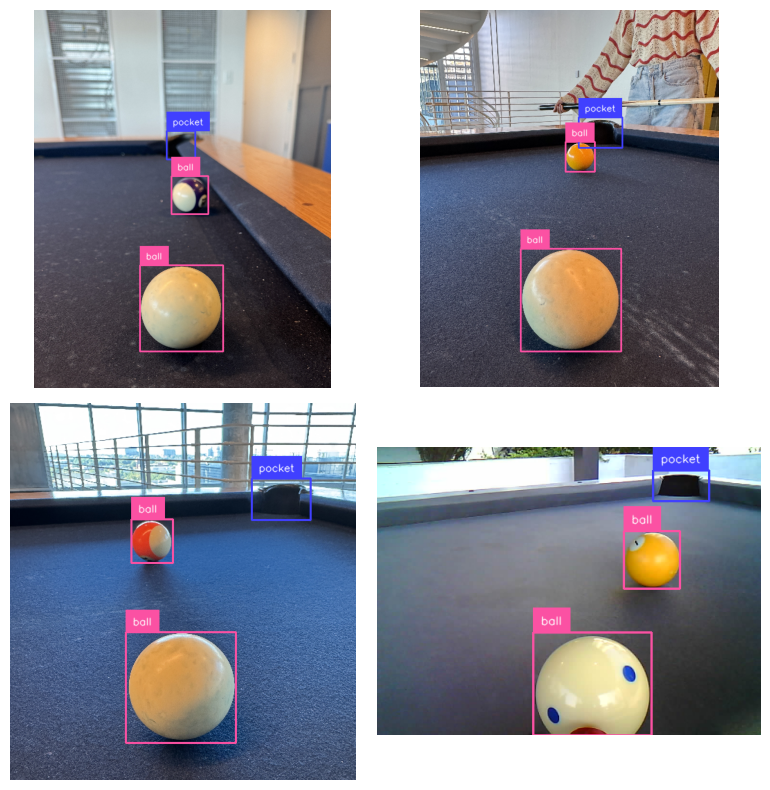

In [24]:
# custom YOLO models
modelb = YOLO('balls.pt')    # For balls
modelp = YOLO('pockets.pt')  # For pockets

class_names = []

for name in modelb.names.values():
    if name not in class_names:
        class_names.append(name)

for name in modelp.names.values():
    if name not in class_names:
        class_names.append(name)

annotated_images = []

for i, resized_image in enumerate(resized_images):
    resized_image_path = f"resized_temp_{i}.jpg"
    cv2.imwrite(resized_image_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

    resultb = modelb.predict(resized_image_path, conf=0.7)[0]
    resultp = modelp.predict(resized_image_path, conf=0.5)[0]
    
    detections = []
    confidence_scores = []
    labels = []
    class_ids = []

    boxes = resultb.boxes.xyxy.cpu().numpy()
    confidences = resultb.boxes.conf.cpu().numpy()
    cls_ids = resultb.boxes.cls.cpu().numpy().astype(int)
    
    for box, conf, cls_id in zip(boxes, confidences, cls_ids):
        x_min, y_min, x_max, y_max = box.astype(int)
        detections.append([x_min, y_min, x_max, y_max])
        confidence_scores.append(conf)
        class_name = modelb.names[cls_id]
        labels.append(class_name)
        class_id = class_names.index(class_name)
        class_ids.append(class_id)
        
    boxes = resultp.boxes.xyxy.cpu().numpy()
    confidences = resultp.boxes.conf.cpu().numpy()
    cls_ids = resultp.boxes.cls.cpu().numpy().astype(int)
    
    for box, conf, cls_id in zip(boxes, confidences, cls_ids):
        x_min, y_min, x_max, y_max = box.astype(int)
        detections.append([x_min, y_min, x_max, y_max])
        confidence_scores.append(conf)
        class_name = modelp.names[cls_id]
        labels.append(class_name)
        class_id = class_names.index(class_name)
        class_ids.append(class_id)
        
    detection_boxes = sv.Detections(
        xyxy=np.array(detections),  
        confidence=np.array(confidence_scores),
        class_id=np.array(class_ids)
    )
    
    labels = [class_names[class_id] for class_id in class_ids]
    
    # annotate image
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    annotated_image = resized_image.copy()
    annotated_image = box_annotator.annotate(
        scene=annotated_image, detections=detection_boxes
    )
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=detection_boxes, labels=labels
    )
    
    annotated_images.append(annotated_image)
    
    if os.path.exists(resized_image_path):
        os.remove(resized_image_path)

display_images_grid(annotated_images, grid_size=(2, 2))

## Angle for Straight Shot


image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_0.jpg: 640x512 2 balls, 189.8ms
Speed: 3.0ms preprocess, 189.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_0.jpg: 640x512 1 pocket, 217.0ms
Speed: 3.9ms preprocess, 217.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)
Image 0: Angle between lines: 0.21 degrees

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_1.jpg: 640x512 2 balls, 210.9ms
Speed: 8.3ms preprocess, 210.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_1.jpg: 640x512 1 pocket, 202.9ms
Speed: 11.2ms preprocess, 202.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)
Image 1: Angle between lines: 10.01 degrees

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_2.jpg: 640x608 2 bal

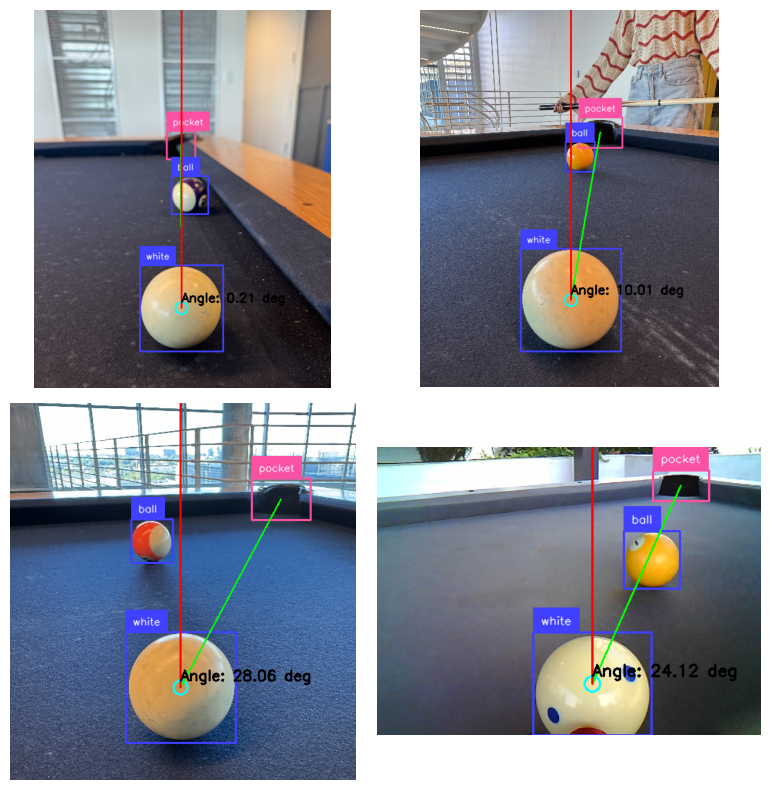

In [25]:
# Load your custom YOLO models
modelb = YOLO('balls.pt')    # For balls
modelp = YOLO('pockets.pt')  # For pockets

annotated_images = []
class_name_to_id = {"pocket": 0, "ball": 1}

for i, resized_image in enumerate(resized_images):
    resized_image_path = f"resized_temp_{i}.jpg"
    cv2.imwrite(resized_image_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

    # Get predictions from both models
    resultb = modelb.predict(resized_image_path, conf=0.7)[0]
    resultp = modelp.predict(resized_image_path, conf=0.5)[0]

    detections = []
    confidence_scores = []
    labels = []
    class_ids = []
    ball_centers = []
    pocket_centers = []
    white_center = None  # Initialize white_center

    # Process predictions from the balls model
    boxes = resultb.boxes.xyxy.cpu().numpy()
    confidences = resultb.boxes.conf.cpu().numpy()

    # Find the white ball (ball with lowest y-center)
    if len(boxes) > 0:
        y_centers = []
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            y_center = (y_min + y_max) / 2
            y_centers.append(y_center)
        white_ball_index = np.argmax(y_centers)

        for idx, (box, conf) in enumerate(zip(boxes, confidences)):
            x_min, y_min, x_max, y_max = box.astype(int)
            x_center = (x_min + x_max) / 2
            y_center = (y_min + y_max) / 2
            detections.append([x_min, y_min, x_max, y_max])
            confidence_scores.append(conf)
            labels.append('ball')
            class_ids.append(class_name_to_id['ball'])
            ball_centers.append((x_center, y_center))

            if idx == white_ball_index:
                white_center = (x_center, y_center)
                labels[-1] = 'white'  # Change label to 'white' for annotation
    else:
        print(f"Image {i}: No balls detected")

    # Process predictions from the pockets model
    boxes_p = resultp.boxes.xyxy.cpu().numpy()
    confidences_p = resultp.boxes.conf.cpu().numpy()

    if len(boxes_p) > 0:
        for box, conf in zip(boxes_p, confidences_p):
            x_min, y_min, x_max, y_max = box.astype(int)
            x_center = (x_min + x_max) / 2
            y_center = (y_min + y_max) / 2
            detections.append([x_min, y_min, x_max, y_max])
            confidence_scores.append(conf)
            labels.append('pocket')
            class_ids.append(class_name_to_id['pocket'])
            pocket_centers.append((x_center, y_center))
    else:
        print(f"Image {i}: No pockets detected")

    if len(detections) == 0:
        print(f"No detections in image {i}")
        annotated_images.append(resized_image)
        continue

    # Create Detections object
    detection_boxes = sv.Detections(
        xyxy=np.array(detections),
        confidence=np.array(confidence_scores),
        class_id=np.array(class_ids)
    )

    # Annotate image
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    annotated_image = resized_image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detection_boxes)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detection_boxes, labels=labels)

    # Draw a circle around the white ball to highlight it
    if white_center is not None:
        cv2.circle(annotated_image, (int(white_center[0]), int(white_center[1])), 10, (0, 255, 255), 2)

    # Annotate lines and calculate angle
    if white_center is not None and pocket_centers:
        pocket_center = pocket_centers[0]

        # Draw line between white ball and pocket
        cv2.line(annotated_image, (int(white_center[0]), int(white_center[1])),
                 (int(pocket_center[0]), int(pocket_center[1])), (0, 255, 0), 2)

        # Draw vertical line from white ball upwards
        vertical_end_point = (int(white_center[0]), 0)
        cv2.line(annotated_image, (int(white_center[0]), int(white_center[1])),
                 vertical_end_point, (255, 0, 0), 2)

        # Calculate angle between the two lines
        vector_line1 = np.array([pocket_center[0] - white_center[0], pocket_center[1] - white_center[1]])
        vector_line2 = np.array([0, -1])  # Vertical line upwards

        # Adjust for zero division
        if np.linalg.norm(vector_line1) != 0:
            angle_rad = np.arccos(np.dot(vector_line1, vector_line2) / (np.linalg.norm(vector_line1) * np.linalg.norm(vector_line2)))
            angle_deg = np.degrees(angle_rad)
        else:
            angle_deg = 0.0

        print(f"Image {i}: Angle between lines: {angle_deg:.2f} degrees")

        # Annotate angle on image
        angle_text = f"Angle: {angle_deg:.2f} deg"
        cv2.putText(annotated_image, angle_text, (int(white_center[0]), int(white_center[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
    else:
        print(f"Image {i}: White ball or pocket not detected")

    annotated_images.append(annotated_image)

    # Clean up temporary image file
    if os.path.exists(resized_image_path):
        os.remove(resized_image_path)

# Display annotated images in a grid
display_images_grid(annotated_images, grid_size=(2, 2))

## Angle for Cut Shot


image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_0.jpg: 640x512 2 balls, 291.3ms
Speed: 9.5ms preprocess, 291.3ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_0.jpg: 640x512 1 pocket, 178.0ms
Speed: 8.0ms preprocess, 178.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)
Image 0: Angle between lines (white to ghost ball): 6.93 degrees

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_1.jpg: 640x512 2 balls, 186.7ms
Speed: 5.2ms preprocess, 186.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\priya\Documents\PythonProjects\PoolShark\resized_temp_1.jpg: 640x512 1 pocket, 185.2ms
Speed: 0.0ms preprocess, 185.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)
Image 1: Angle between lines (white to ghost ball): 0.07 degrees

image 1/1 c:\Users\priya\Documents\PythonProjects\P

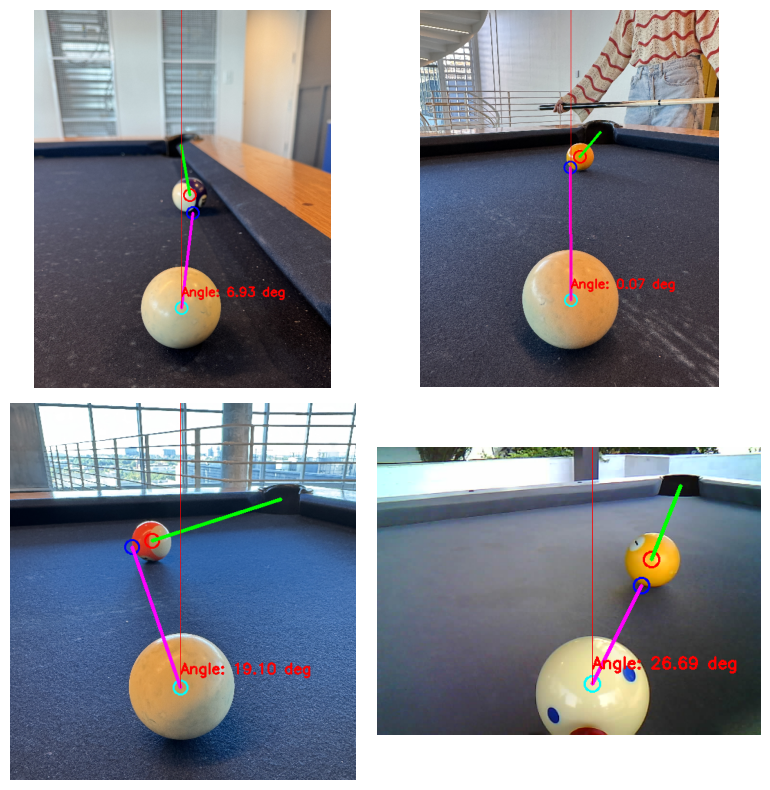

In [ ]:
# Load your custom YOLO models
modelb = YOLO('balls.pt')    # For balls
modelp = YOLO('pockets.pt')  # For pockets

annotated_images = []
class_name_to_id = {"pocket": 0, "ball": 1}

for i, resized_image in enumerate(resized_images):
    resized_image_path = f"resized_temp_{i}.jpg"
    cv2.imwrite(resized_image_path, cv2.cvtColor(resized_image, cv2.COLOR_RGB2BGR))

    # Get predictions from both models
    resultb = modelb.predict(resized_image_path, conf=0.7)[0]
    resultp = modelp.predict(resized_image_path, conf=0.5)[0]

    detections = []
    confidence_scores = []
    labels = []
    class_ids = []
    ball_centers = []
    pocket_centers = []
    white_center = None
    target_center = None
    target_diameter = None

    # Process predictions from the balls model
    boxes = resultb.boxes.xyxy.cpu().numpy()
    confidences = resultb.boxes.conf.cpu().numpy()

    if len(boxes) > 0:
        y_centers = []
        ball_diameters = []
        for box in boxes:
            x_min, y_min, x_max, y_max = box
            y_center = (y_min + y_max) / 2
            y_centers.append(y_center)
            diameter = x_max - x_min  # Assuming the ball is roughly circular
            ball_diameters.append(diameter)
        white_ball_index = np.argmax(y_centers)
        target_ball_index = np.argmin(y_centers)

        for idx, (box, conf) in enumerate(zip(boxes, confidences)):
            x_min, y_min, x_max, y_max = box.astype(int)
            x_center = (x_min + x_max) / 2
            y_center = (y_min + y_max) / 2
            diameter = x_max - x_min  # Ball diameter in pixels

            detections.append([x_min, y_min, x_max, y_max])
            confidence_scores.append(conf)
            labels.append('ball')
            class_ids.append(class_name_to_id['ball'])
            ball_centers.append((x_center, y_center))

            if idx == white_ball_index:
                white_center = (x_center, y_center)
                labels[-1] = 'white'  # Change label to 'white' for annotation
            elif idx == target_ball_index:
                target_center = (x_center, y_center)
                target_diameter = diameter
                labels[-1] = 'target'  # Change label to 'target' for annotation
    else:
        print(f"Image {i}: No balls detected")

    # Process predictions from the pockets model
    boxes_p = resultp.boxes.xyxy.cpu().numpy()
    confidences_p = resultp.boxes.conf.cpu().numpy()

    if len(boxes_p) > 0:
        for box, conf in zip(boxes_p, confidences_p):
            x_min, y_min, x_max, y_max = box.astype(int)
            x_center = (x_min + x_max) / 2
            y_center = (y_min + y_max) / 2
            detections.append([x_min, y_min, x_max, y_max])
            confidence_scores.append(conf)
            labels.append('pocket')
            class_ids.append(class_name_to_id['pocket'])
            pocket_centers.append((x_center, y_center))
    else:
        print(f"Image {i}: No pockets detected")

    if len(detections) == 0:
        print(f"No detections in image {i}")
        annotated_images.append(resized_image)
        continue

    # Create Detections object
    detection_boxes = sv.Detections(
        xyxy=np.array(detections),
        confidence=np.array(confidence_scores),
        class_id=np.array(class_ids)
    )

    # Annotate image
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    annotated_image = resized_image.copy()
    # annotated_image = box_annotator.annotate(scene=annotated_image, detections=detection_boxes)
    # annotated_image = label_annotator.annotate(scene=annotated_image, detections=detection_boxes, labels=labels)

    # Draw a circle around the white ball to highlight it
    if white_center is not None:
        cv2.circle(annotated_image, (int(white_center[0]), int(white_center[1])), 10, (0, 255, 255), 2)

    # Draw a circle around the target ball to highlight it
    if target_center is not None:
        cv2.circle(annotated_image, (int(target_center[0]), int(target_center[1])), 10, (255, 0, 0), 2)

    # Annotate lines and calculate angle
    if white_center is not None and target_center is not None and pocket_centers:
        pocket_center = pocket_centers[0]

        # Draw line between target ball and pocket
        cv2.line(annotated_image, (int(target_center[0]), int(target_center[1])),
                 (int(pocket_center[0]), int(pocket_center[1])), (0, 255, 0), 3) 

        # Compute vector from target ball to pocket
        vec_target_to_pocket = np.array([pocket_center[0] - target_center[0],
                                         pocket_center[1] - target_center[1]])
        norm_vec = np.linalg.norm(vec_target_to_pocket)
        if norm_vec != 0:
            unit_vec = vec_target_to_pocket / norm_vec
        else:
            unit_vec = np.array([0, 0])  # Avoid division by zero

        # Compute ghost ball location by extending the line beyond the target ball
        ghost_center = target_center - unit_vec * (target_diameter * 0.75)

        # Draw a circle at the ghost ball location
        cv2.circle(annotated_image, (int(ghost_center[0]), int(ghost_center[1])), 10, (0, 0, 255), 2)  # Red circle

        # Draw line from white ball to ghost ball
        cv2.line(annotated_image, (int(white_center[0]), int(white_center[1])),
                 (int(ghost_center[0]), int(ghost_center[1])), (255, 0, 255), 3)  # Purple line

        # Draw vertical line from white ball upwards
        vertical_end_point = (int(white_center[0]), 0)
        cv2.line(annotated_image, (int(white_center[0]), int(white_center[1])),
                 vertical_end_point, (255, 0, 0), 1)

        # Calculate angle between the two lines (white to ghost ball and vertical)
        vector_line1 = np.array([ghost_center[0] - white_center[0], ghost_center[1] - white_center[1]])
        vector_line2 = np.array([0, -1])  # Vertical line upwards

        # Adjust for zero division
        if np.linalg.norm(vector_line1) != 0:
            angle_rad = np.arccos(np.dot(vector_line1, vector_line2) / (
                np.linalg.norm(vector_line1) * np.linalg.norm(vector_line2)))
            angle_deg = np.degrees(angle_rad)
        else:
            angle_deg = 0.0

        print(f"Image {i}: Angle between lines (white to ghost ball): {angle_deg:.2f} degrees")

        # Annotate angle on image
        angle_text = f"Angle: {angle_deg:.2f} deg"
        cv2.putText(annotated_image, angle_text, (int(white_center[0]), int(white_center[1]) - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    else:
        print(f"Image {i}: White ball, target ball, or pocket not detected")

    annotated_images.append(annotated_image)

    # Clean up temporary image file
    if os.path.exists(resized_image_path):
        os.remove(resized_image_path)

# Display annotated images in a grid
display_images_grid(annotated_images, grid_size=(2, 2))